### 2D UNet for Image Segmentation in Digital Rock Petrophysics
#### Ahad Momin (ahadmomin16@gmail.com)
##### [GitHub](https://github.com/AhadMomin) | [Website](http://ahadmomin.github.io) |
#### Supervisor: Christoph Arns & Masa Prodanovic
#### Digital Rock Petrophysics

### 2D UNet:
#### The UNet Architecture is inspired by:  | [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) |

#### 2D UNet Model:




This deep neural network is implemented with Tensorflow and Keras functional API, which makes it extremely easy to experiment with different interesting architectures using GPU based enivronment


#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

#### Load the required libraries

The following code loads the required libraries.

Some of the workflow Style is inspired by: Prof Micheal Pyrcz

In [6]:
import os
import random
import tifffile as tff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import notebook, tnrange
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import cv2

### Load Images

In [7]:
os.chdir("C:/Users/ahadm/Documents/UNSW Research/image segmentation CNN/UNET CNN/")

In [8]:
image_size = 128
epochs= 5
batch_size = 1
path = "train_data/"

In [13]:
ids = next(os.walk(path))[1]
print("Numnber of images = ", len(ids))

X = np.zeros((len(ids), image_size, image_size, 3))
y = np.zeros((len(ids), image_size, image_size, 1))

for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load Tomogram
    img = cv2.imread(path+id_+"/images/"+id_+".png", 1)
    img = cv2.resize(img, (image_size, image_size))
    # Load segmented images
    segmented = cv2.imread(path+id_+"/segmented/"+id_+".png")
    segmented = resize(segmented, (image_size, image_size, 1), mode = 'constant', preserve_range = True)
     # Normalize and store images
    X[n] = img/255.0
    y[n] = segmented/255.0

Numnber of images =  1311


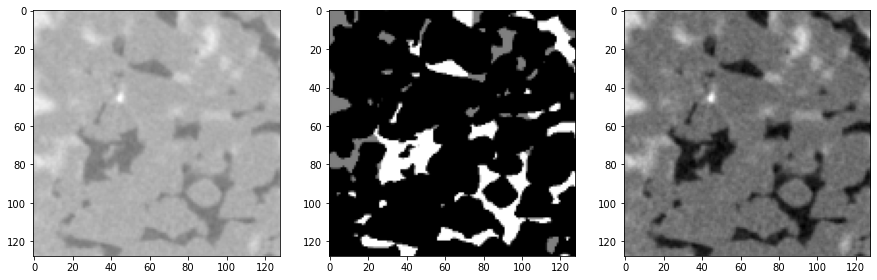

In [14]:
r = random.randint(0, len(X)-1)

fig, ax = plt.subplots(1, 3, figsize = (15, 15))
ax[0].imshow(X[r])
ax[2].imshow(X[r,...,1], cmap="gray")
ax[1].imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

### Train and Test Split & vizualize

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [16]:
print("Tomogram dimension in Training = ", X_train.shape)
print("Segmented dimension in Training  = ",y_train.shape)
print("Tomogram dimension in Testing = ",X_test.shape)
print("Segmented dimension in Testing = ",y_test.shape)

Tomogram dimension in Training =  (1048, 128, 128, 3)
Segmented dimension in Training  =  (1048, 128, 128, 1)
Tomogram dimension in Testing =  (263, 128, 128, 3)
Segmented dimension in Testing =  (263, 128, 128, 1)


Text(0.5, 1.0, 'Segmented(GR)')

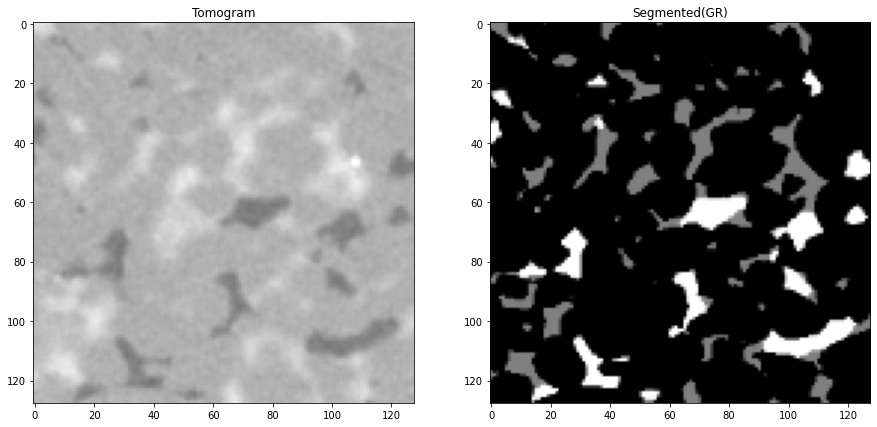

In [17]:
r= random.randint(0, len(X_train-1))
fig, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(X_train[r])
ax[0].set_title('Tomogram')
ax[1].imshow(y_train[r].squeeze(), cmap = 'gray')
ax[1].set_title('Segmented(GR)')

## 2D UNet Model

In [9]:
def Unet2D(featuremaps):
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(inputs)
    conv1 = batch_Norm_Activation(conv1)
    conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(conv1)
    conv1 = batch_Norm_Activation(conv1)
    pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(pool1)
    conv2 = batch_Norm_Activation(conv2)
    conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv2)
    conv2 = batch_Norm_Activation(conv2)
    pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(pool2)
    conv3 = batch_Norm_Activation(conv3)
    conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3),padding="same")(conv3)
    conv3 = batch_Norm_Activation(conv3)
    pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(pool3)
    conv4 = batch_Norm_Activation(conv4)
    conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv4)
    conv4 = batch_Norm_Activation(conv4)
    pool4 = keras.layers.MaxPooling2D((2, 2))(conv4)

    convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(pool4)
    convm = batch_Norm_Activation(convm)
    convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
    convm = batch_Norm_Activation(convm)
    
    deconv4 = keras.layers.Conv2DTranspose(featuremaps * 8, (2, 2), strides=(2, 2), padding="same")(convm)
    uconv4 = keras.layers.concatenate([deconv4, conv4])
    uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
    uconv4 = batch_Norm_Activation(uconv4)
    uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
    uconv4 = batch_Norm_Activation(uconv4)

    deconv3 = keras.layers.Conv2DTranspose(featuremaps * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
    uconv3 = keras.layers.concatenate([deconv3, conv3])
    uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
    uconv3 = batch_Norm_Activation(uconv3)
    uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
    uconv3 = batch_Norm_Activation(uconv3)

    deconv2 = keras.layers.Conv2DTranspose(featuremaps * 2, (2, 2), strides=(2, 2), padding="same")(uconv3)
    uconv2 = keras.layers.concatenate([deconv2, conv2])
    uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
    uconv2 = batch_Norm_Activation(uconv2)
    uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
    uconv2 = batch_Norm_Activation(uconv2)

    deconv1 = keras.layers.Conv2DTranspose(featuremaps * 1, (2, 2), strides=(2, 2), padding="same")(uconv2)
    uconv1 = keras.layers.concatenate([deconv1, conv1])
    uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
    uconv1 = batch_Norm_Activation(uconv1)
    uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
    uconv1 = batch_Norm_Activation(uconv1)
    
    output_layer = keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    model = keras.models.Model(inputs, output_layer)
    return model

## To Turn off Batch Normalization, Change BN to False >

def batch_Norm_Activation(x, BN=True):
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x= keras.layers.Activation("relu")(x)
    return x

### Run the Model

In [12]:
model = Unet2D(64)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-9, momentum=0.9)
model.compile(optimizer=sgd, loss="mean_squared_error", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-tgs-segmentation_05epochs1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

### Train the Model

In [14]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Train on 1048 samples, validate on 263 samples
Epoch 1/5
1048/1048 [==============================] - 157s 150ms/step - loss: 0.0081 - accuracy: 0.7713 - val_loss: 0.0078 - val_accuracy: 0.7682

Epoch 00001: val_loss improved from inf to 0.00778, saving model to model-tgs-segmentation_05epochs1.h5
Epoch 2/5
1048/1048 [==============================] - 182s 173ms/step - loss: 0.0048 - accuracy: 0.7726 - val_loss: 0.0049 - val_accuracy: 0.7685

Epoch 00002: val_loss improved from 0.00778 to 0.00490, saving model to model-tgs-segmentation_05epochs1.h5
Epoch 3/5
1048/1048 [==============================] - 221s 211ms/step - loss: 0.0044 - accuracy: 0.7726 - val_loss: 0.0051 - val_accuracy: 0.7681

Epoch 00003: val_loss did not improve from 0.00490
Epoch 4/5
1048/1048 [==============================] - 245s 234ms/step - loss: 0.0043 - accuracy: 0.7726 - val_loss: 0.0047 - val_accuracy: 0.7682

Epoch 00004: val_loss improved from 0.00490 to 0.00473, saving model to model-tgs-segmentation_05e

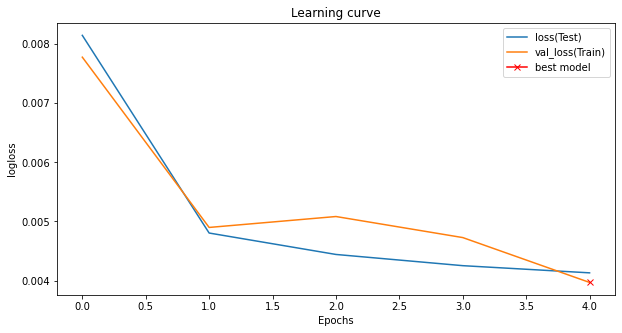

In [35]:
plt.figure(figsize=(10, 5))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss(Test)")
plt.plot(hist.history["val_loss"], label="val_loss(Train)")
plt.plot(np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("logloss")
plt.legend();

In [16]:
model.load_weights('model-tgs-segmentation_05epochs1.h5')
model.evaluate(X_test, y_test, verbose=1) 

263/263 [==============================] - 14s 52ms/step


[0.003967312104405106, 0.7686716318130493]

In [17]:
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

263/263 [==============================] - 7s 27ms/step


In [30]:
def plot_sample(X, y, preds, r=None):
    if r is None:
        r = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[r])
    print(X[r, ..., 0].shape)
    ax[0].set_title('tomogram')

    ax[1].imshow(y[r].squeeze()*255,cmap= 'gray')
    print(y[r].squeeze().shape)
    ax[1].set_title('Segmented(GR)')

    ax[2].imshow(preds[r].squeeze()*255,cmap='gray')
    print(preds[r].squeeze().shape)
    ax[2].set_title('Prediction')

### Prediction on Training Dataset

(128, 128)
(128, 128)
(128, 128)


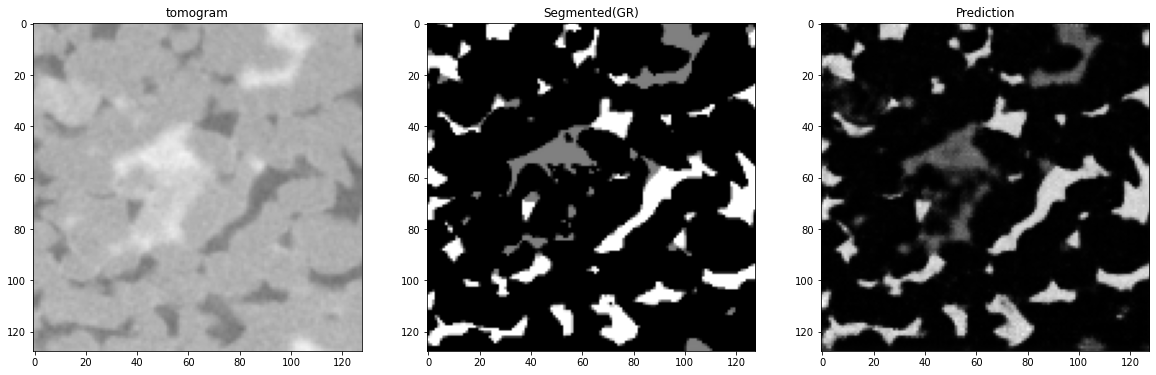

In [46]:
plot_sample(X_train, y_train, preds_train, r=11)

(128, 128)
(128, 128)
(128, 128)


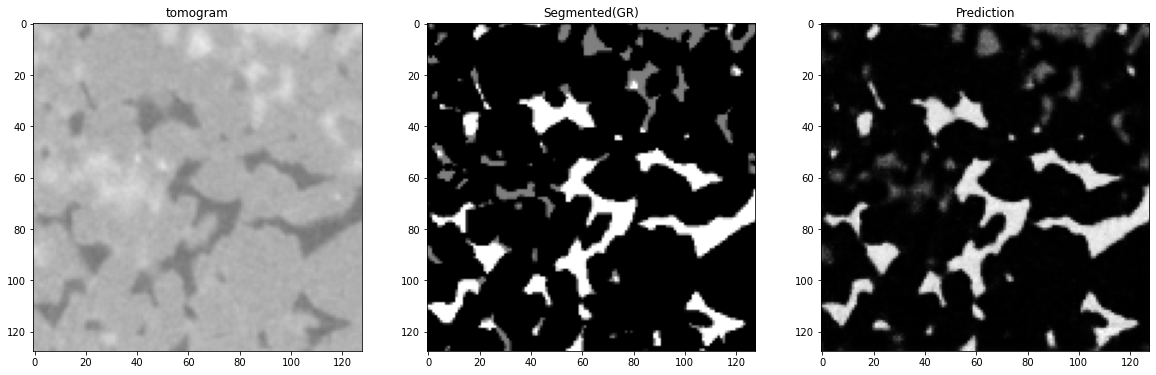

In [47]:
plot_sample(X_train, y_train, preds_train)

### Predication on Testing dataset

(128, 128)
(128, 128)
(128, 128)


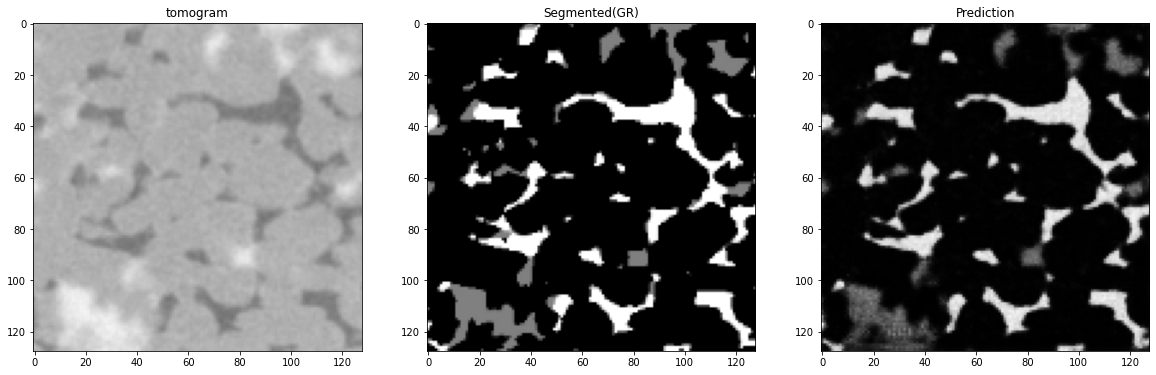

In [33]:
plot_sample(X_test, y_test, preds_test)

(128, 128)
(128, 128)
(128, 128)


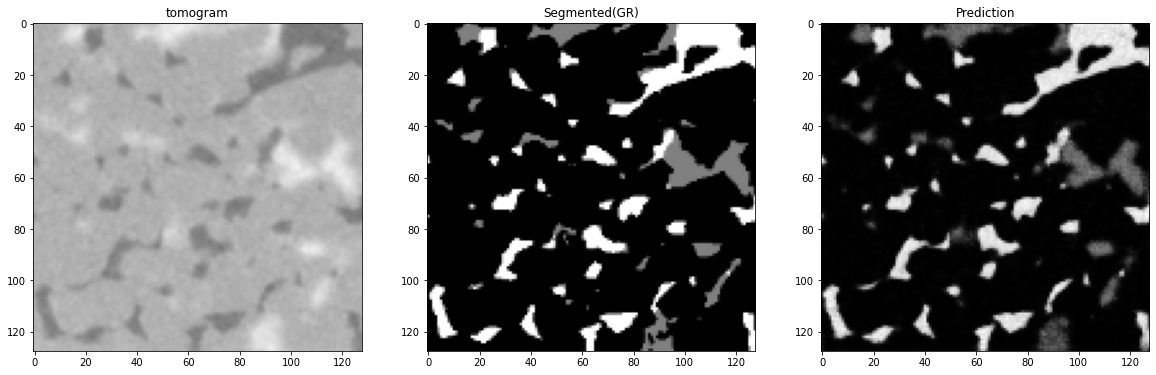

In [34]:
plot_sample(X_test, y_test, preds_test)